## **Setup Data**

In [1]:
import pandas as pd

train_df = pd.read_csv("imdb_synthetic_data/imdb_arh_synthetic_train.csv")
val_df   = pd.read_csv("imdb_synthetic_data/imdb_arh_synthetic_val.csv")
test_df  = pd.read_csv("imdb_synthetic_data/imdb_arh_synthetic_test.csv")

print(train_df.head())

                                            synopsis    genre
0  end young motivated and images murder beautifu...  romance
1  franz rolondo sacrifice on apoorva hariya an a...  romance
2  sturgess will task infamous and racing elena a...   action
3  the parents model for cross marriage thailand ...  romance
4  speeding they film gerald are when of give str...   action


In [2]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_df['genre'])

y_train = label_encoder.transform(train_df['genre'])
y_val   = label_encoder.transform(val_df['genre'])
y_test  = label_encoder.transform(test_df['genre'])

num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

Classes: ['action' 'horror' 'romance']


In [3]:
def clean_text(text):
    if isinstance(text, str):
        # remove punctuation for cleaner tokens 
        text = text.replace('.', '').replace(',', '').replace('"', '') 
        return text.lower()
    return ""

train_df['synopsis'] = train_df['synopsis'].apply(clean_text)
val_df['synopsis'] = val_df['synopsis'].apply(clean_text)
test_df['synopsis'] = test_df['synopsis'].apply(clean_text)

## **Train & Evaluate Model**

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 20000
MAX_LEN = 200   

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<UNK>")
tokenizer.fit_on_texts(train_df['synopsis'])

X_train = tokenizer.texts_to_sequences(train_df['synopsis'])
X_val   = tokenizer.texts_to_sequences(val_df['synopsis'])
X_test  = tokenizer.texts_to_sequences(test_df['synopsis'])

X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_val   = pad_sequences(X_val, maxlen=MAX_LEN)
X_test  = pad_sequences(X_test, maxlen=MAX_LEN)

c:\Users\Anish Parmar\anaconda3\envs\p4ml\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Anish Parmar\anaconda3\envs\p4ml\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Anish Parmar\anaconda3\envs\p4ml\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.1 at tensorflow/core/framework/resource_handle.proto. Please update

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from tensorflow.keras.layers import Bidirectional

model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

c:\Users\Anish Parmar\anaconda3\envs\p4ml\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 555s 419ms/step - accuracy: 0.5933 - loss: 0.7204 - val_accuracy: 0.6534 - val_loss: 0.5316
Epoch 2/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 574s 437ms/step - accuracy: 0.6574 - loss: 0.5448 - val_accuracy: 0.6271 - val_loss: 0.6148
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 549s 418ms/step - accuracy: 0.7446 - loss: 0.4540 - val_accuracy: 0.9536 - val_loss: 0.1477
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 554s 422ms/step - accuracy: 0.9661 - loss: 0.1147 - val_accuracy: 0.9718 - val_loss: 0.0966
Epoch 5/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 574s 437ms/step - accuracy: 0.9865 - loss: 0.0491 - val_accuracy: 0.9797 - val_loss: 0.0914
Epoch 6/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 578s 440ms/step - accuracy: 0.9915 - loss: 0.0304 - val_accuracy: 0.9769 - val_loss: 0.1025
Epoch 7/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 580s 442ms/step - accuracy: 0.9949 - loss: 0.0194 - val_accuracy: 0.9791 - val_loss: 0.1066
Epoch 8/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 584s 445ms/step - ac

In [7]:
# save model
model.save("saved_models/imdb_bilstm_synthetic_model_v1.keras")

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

282/282 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.9814 - loss: 0.0792
Test accuracy: 0.9814444184303284


282/282 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step


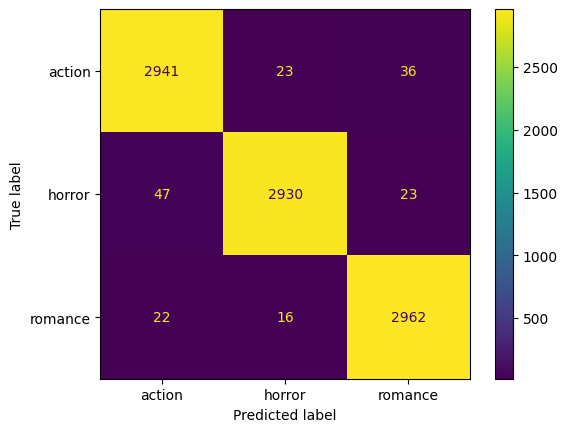

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot()

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      action       0.98      0.98      0.98      3000
      horror       0.99      0.98      0.98      3000
     romance       0.98      0.99      0.98      3000

    accuracy                           0.98      9000
   macro avg       0.98      0.98      0.98      9000
weighted avg       0.98      0.98      0.98      9000

